In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json
from bench_utils import parse_intersection_data 

In [2]:
# Geometries
manual_data, _ = parse_intersection_data("manual")
world_data, world_data_stats = parse_intersection_data("world.json", 10, strip_precision=False)
lund_data, lund_data_stats = parse_intersection_data("lund.json", 10000)

In [3]:
SHOW_COORDINATES = True
SHOW_GEOMETRIES = True
SHOW_INTERSECTING_POINTS = True
SHOW_COMMON_BOUNDING_BOX = True
SHOW_BOUNDING_BOXES = True

In [4]:
import intersection.first_bin_search
import intersection.chunk_bbox_intersection
binary_intersection = intersection.first_bin_search.binary_intersection
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting
chunk_bbox_intersection = intersection.chunk_bbox_intersection.intersection

from intersection.plotting import *

from algos.alg_fpd_extended import FpdExtended
fpd = FpdExtended()

Passed 100 of 100. Total in set: 10000
Passed 200 of 200. Total in set: 10000
Passed 300 of 300. Total in set: 10000
Passed 400 of 400. Total in set: 10000
Passed 500 of 500. Total in set: 10000
Passed 600 of 600. Total in set: 10000
Passed 700 of 700. Total in set: 10000
Passed 800 of 800. Total in set: 10000
Passed 900 of 900. Total in set: 10000
Passed 1000 of 1000. Total in set: 10000
Passed 1100 of 1100. Total in set: 10000
Passed 1200 of 1200. Total in set: 10000
Passed 1300 of 1300. Total in set: 10000
Passed 1400 of 1400. Total in set: 10000
Passed 1500 of 1500. Total in set: 10000
Passed 1600 of 1600. Total in set: 10000
Passed 1700 of 1700. Total in set: 10000
Passed 1800 of 1800. Total in set: 10000
Passed 1900 of 1900. Total in set: 10000
Passed 2000 of 2000. Total in set: 10000
Passed 2100 of 2100. Total in set: 10000
Passed 2200 of 2200. Total in set: 10000
Above FAILED!
Expected shape: LINESTRING (13.1848916 55.7050272, 13.1848975 55.7050028, 13.18493 55.704868, 13.18494

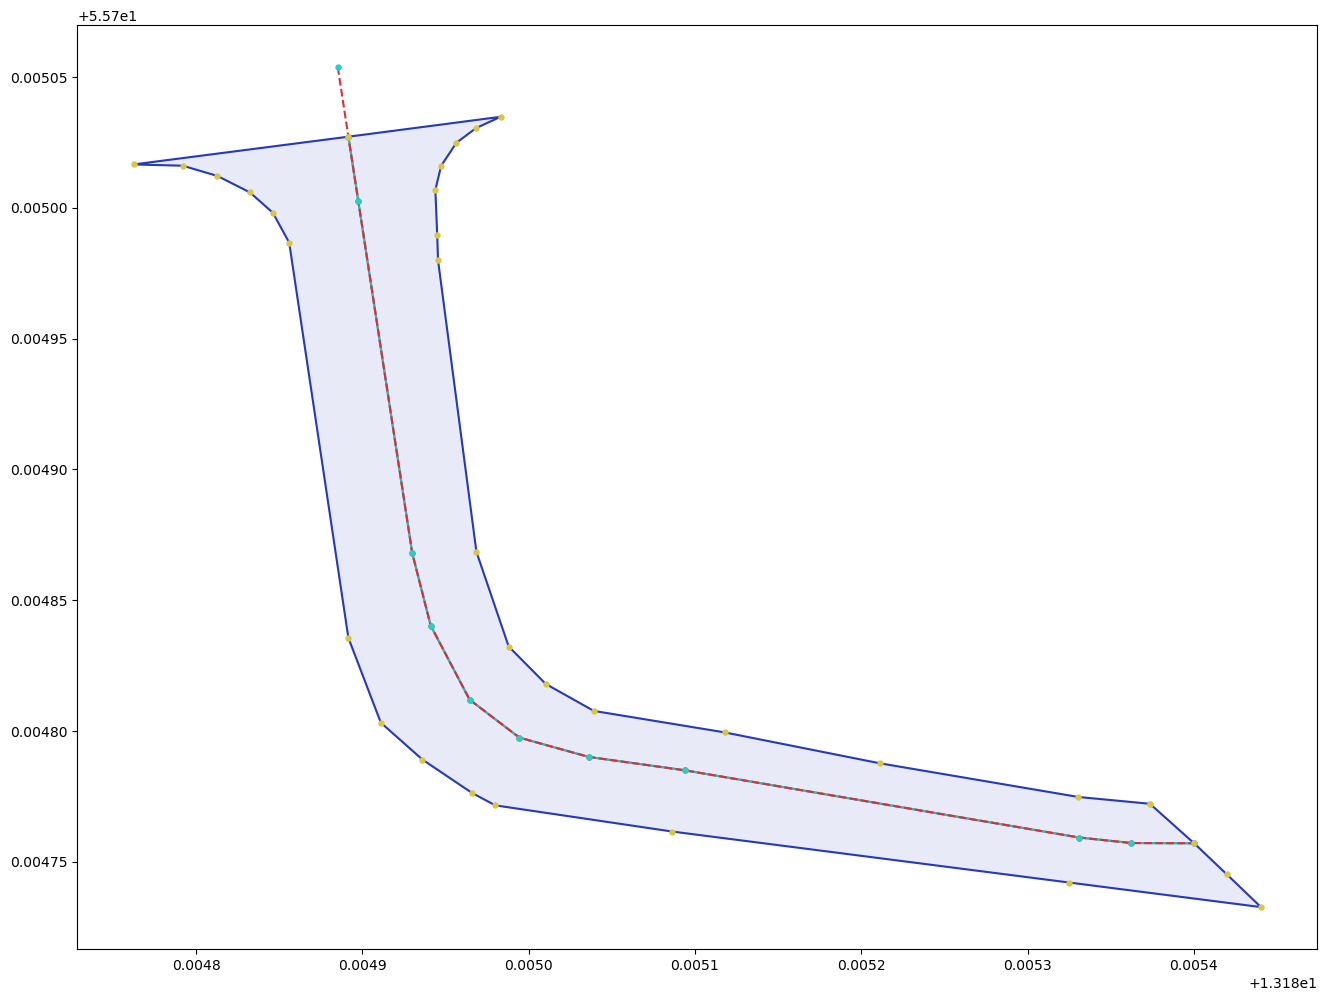

Passed 2299 of 2300. Total in set: 10000
Passed 2399 of 2400. Total in set: 10000
Passed 2499 of 2500. Total in set: 10000
Passed 2599 of 2600. Total in set: 10000
Passed 2699 of 2700. Total in set: 10000
Passed 2799 of 2800. Total in set: 10000
Passed 2899 of 2900. Total in set: 10000
Passed 2999 of 3000. Total in set: 10000
Passed 3099 of 3100. Total in set: 10000
Passed 3199 of 3200. Total in set: 10000
Passed 3299 of 3300. Total in set: 10000
Passed 3399 of 3400. Total in set: 10000
Passed 3499 of 3500. Total in set: 10000
Passed 3599 of 3600. Total in set: 10000
Passed 3699 of 3700. Total in set: 10000
Passed 3799 of 3800. Total in set: 10000
Passed 3899 of 3900. Total in set: 10000
Passed 3999 of 4000. Total in set: 10000
Passed 4099 of 4100. Total in set: 10000
Passed 4199 of 4200. Total in set: 10000
Passed 4299 of 4300. Total in set: 10000
Passed 4399 of 4400. Total in set: 10000
Passed 4499 of 4500. Total in set: 10000
Passed 4599 of 4600. Total in set: 10000
Passed 4699 of 4

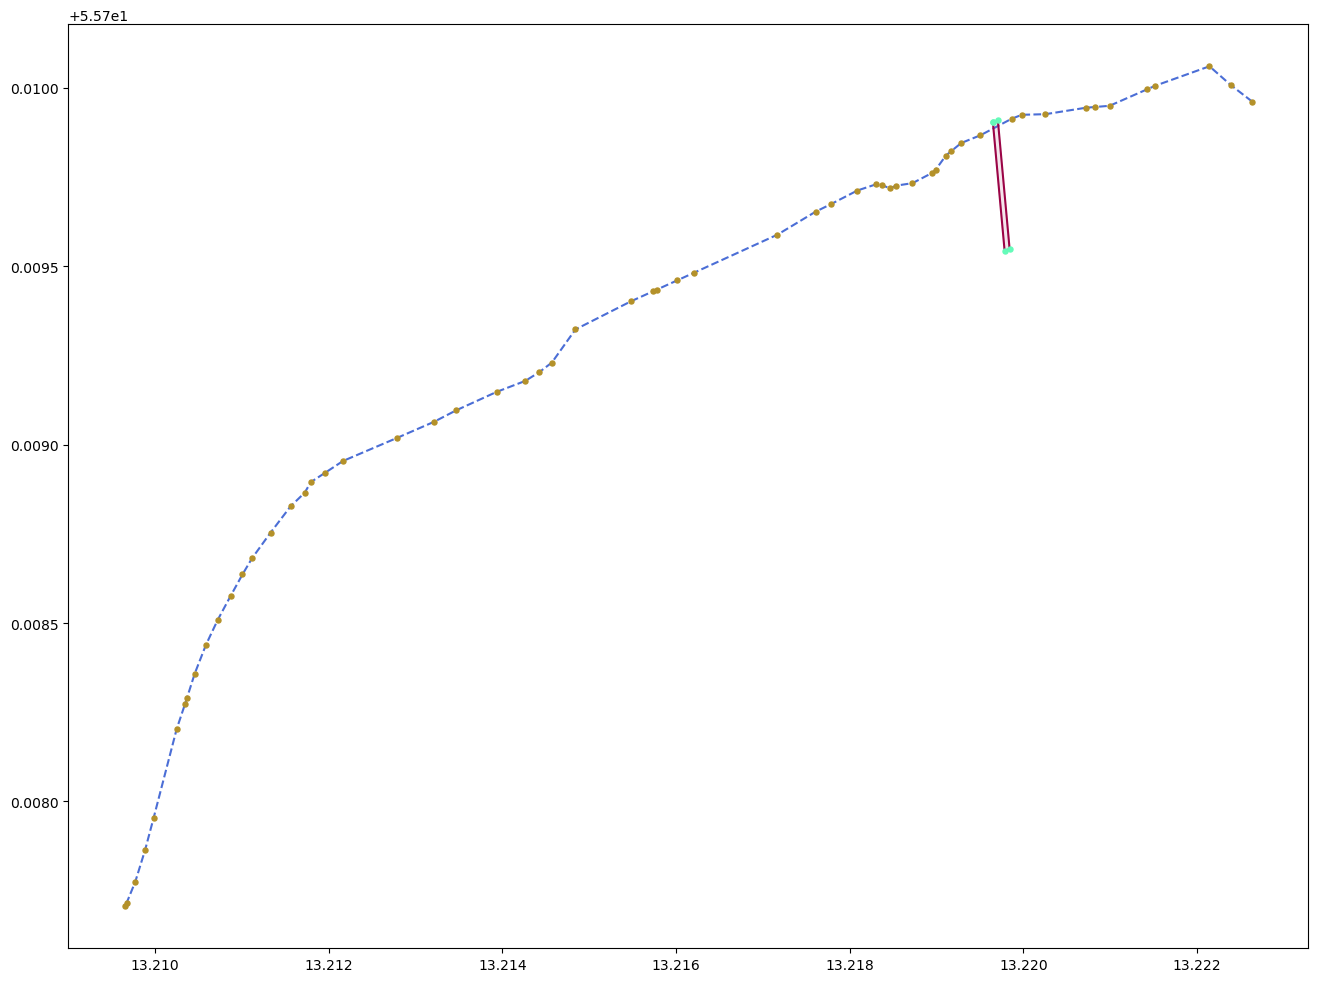

Passed 8198 of 8200. Total in set: 10000
Passed 8298 of 8300. Total in set: 10000
Above FAILED!
Expected shape: MULTILINESTRING ((13.177691 55.6903924, 13.1771269 55.6904103, 13.177107 55.6903099), (13.177107 55.6903099, 13.1770847 55.690246, 13.177091 55.6901992, 13.1771505 55.6901503, 13.1772802 55.6901248, 13.1773971 55.6901269, 13.1774885 55.6901482, 13.1775289 55.690195, 13.1775268 55.6902438, 13.1774651 55.6902906, 13.177327 55.6903097, 13.177107 55.6903099))
Returned shape: GEOMETRYCOLLECTION (LINESTRING (13.177691 55.6903924, 13.1771269 55.6904103, 13.177107 55.6903099), POLYGON ((13.177107 55.6903099, 13.1770847 55.690246, 13.177091 55.6901992, 13.1771505 55.6901503, 13.1772802 55.6901248, 13.1773971 55.6901269, 13.1774885 55.6901482, 13.1775289 55.690195, 13.1775268 55.6902438, 13.1774651 55.6902906, 13.177327 55.6903097, 13.177107 55.6903099)))


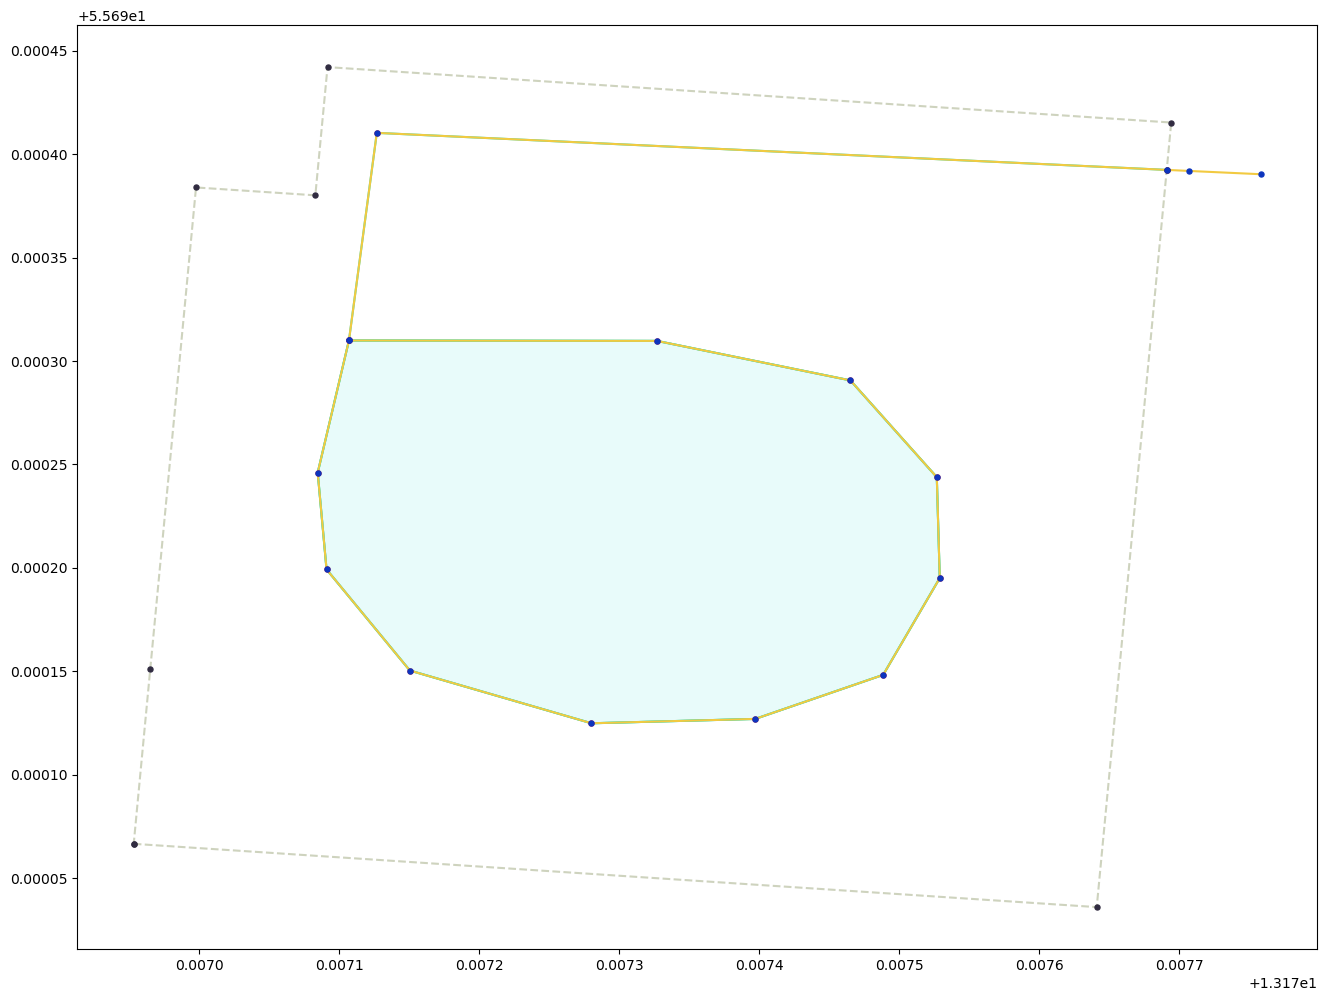

Above FAILED!
Expected shape: MULTILINESTRING ((13.172479 55.691255, 13.1719862 55.6914025, 13.1718898 55.6913058), (13.1718898 55.6913058, 13.1717432 55.6911681, 13.1721238 55.691048, 13.1722627 55.6911861, 13.1718898 55.6913058))
Returned shape: GEOMETRYCOLLECTION (LINESTRING (13.172479 55.691255, 13.1719862 55.6914025, 13.1718898 55.6913058), POLYGON ((13.1718898 55.6913058, 13.1717432 55.6911681, 13.1721238 55.691048, 13.1722627 55.6911861, 13.1718898 55.6913058)))


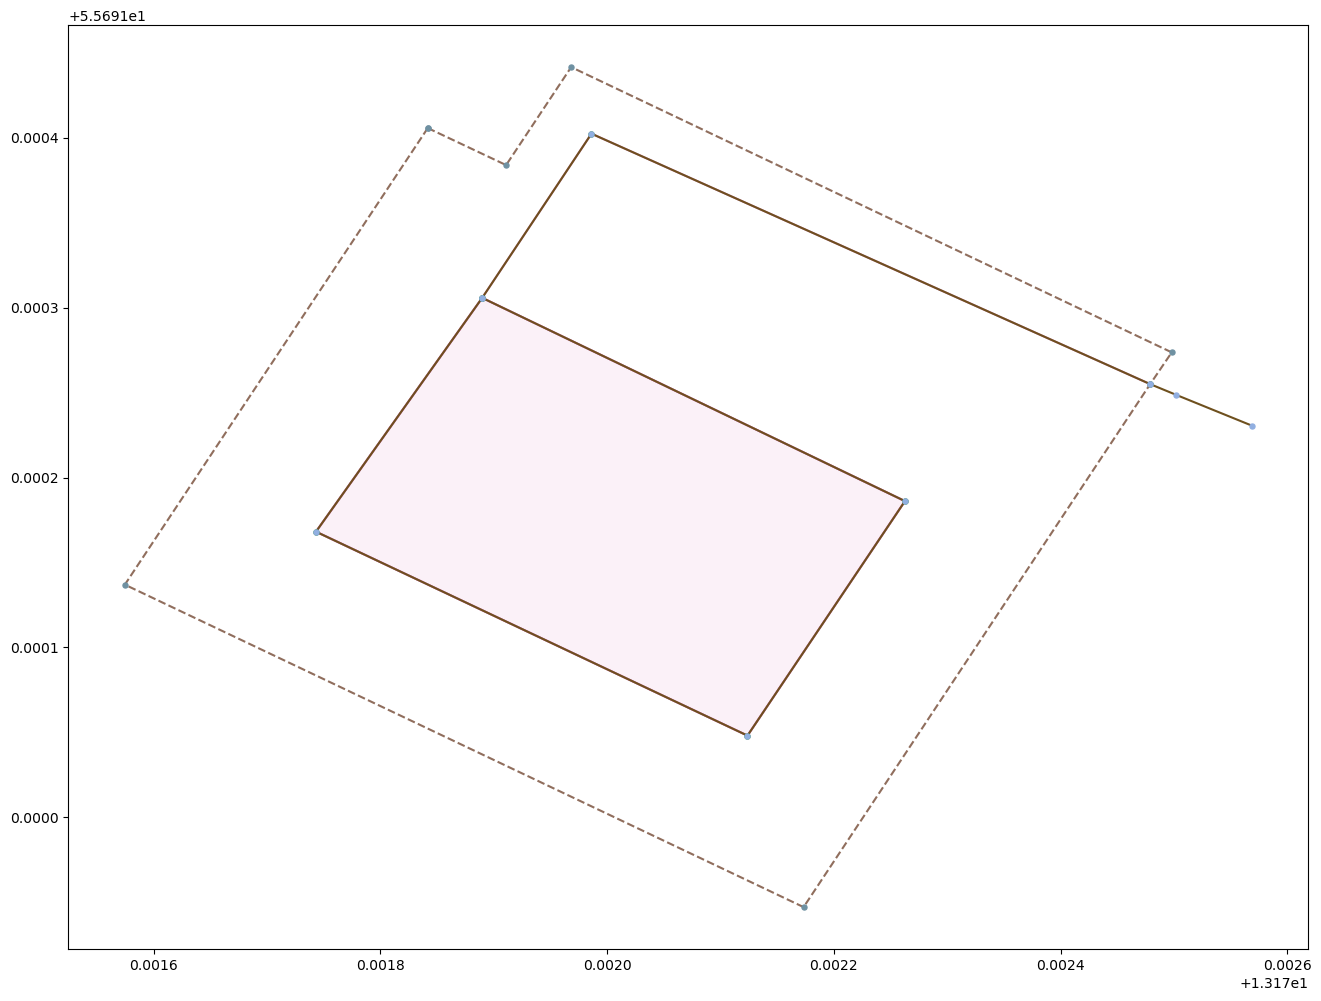

Above FAILED!
Expected shape: MULTILINESTRING ((13.1750091 55.6906658, 13.174474 55.6907478, 13.1744197 55.6906428), (13.1744197 55.6906428, 13.1743239 55.6904895, 13.1747232 55.6904173, 13.1748124 55.6905755, 13.1744197 55.6906428))
Returned shape: GEOMETRYCOLLECTION (LINESTRING (13.1750091 55.6906658, 13.174474 55.6907478, 13.1744197 55.6906428), POLYGON ((13.1744197 55.6906428, 13.1743239 55.6904895, 13.1747232 55.6904173, 13.1748124 55.6905755, 13.1744197 55.6906428)))


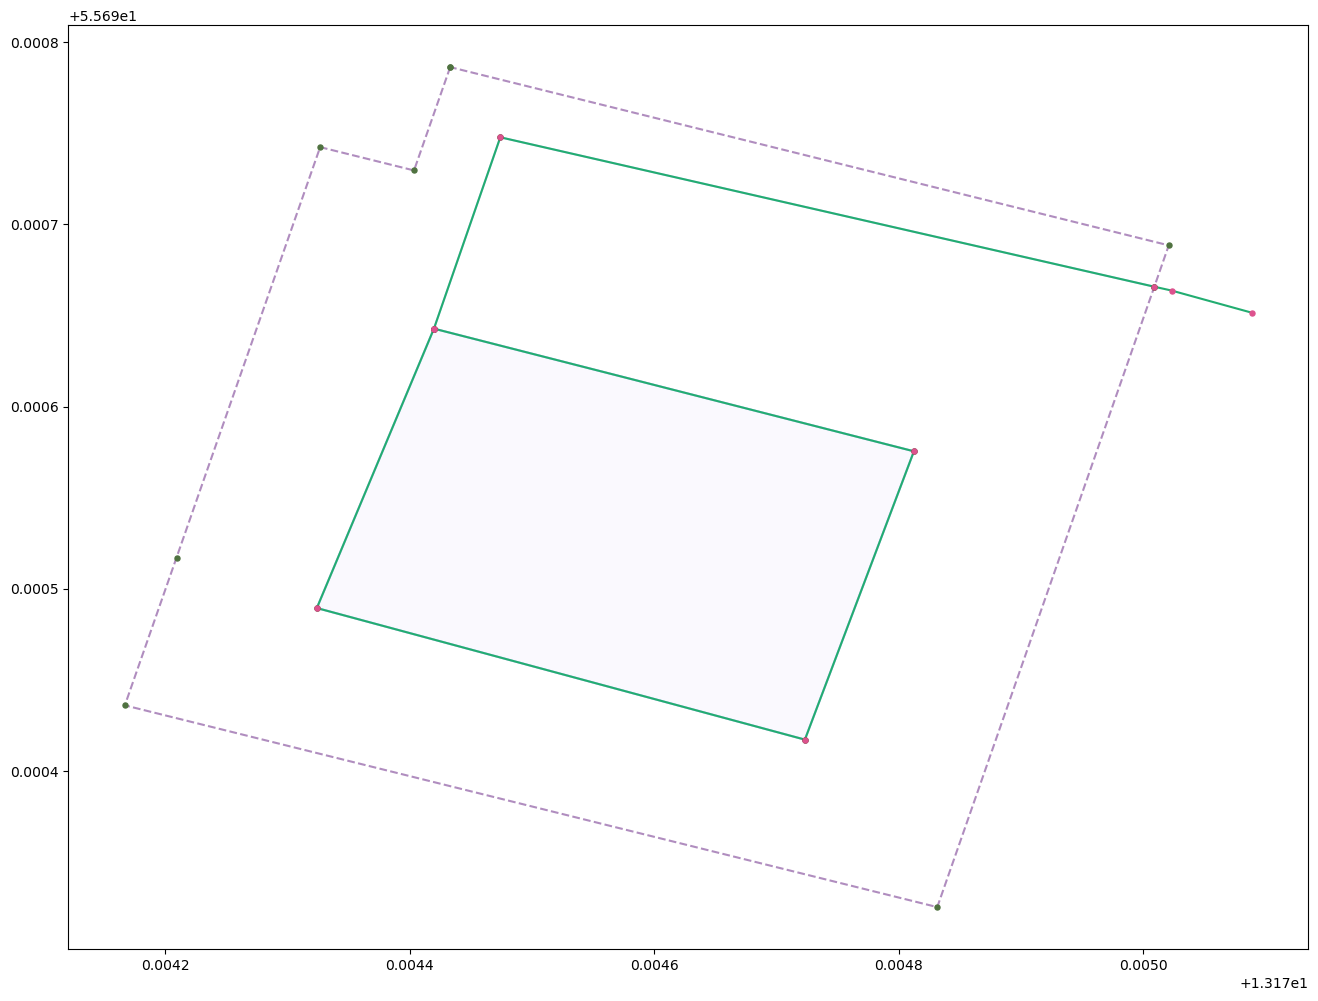

Passed 8395 of 8400. Total in set: 10000
Passed 8495 of 8500. Total in set: 10000
Passed 8595 of 8600. Total in set: 10000
Passed 8695 of 8700. Total in set: 10000
Passed 8795 of 8800. Total in set: 10000
Above FAILED!
Expected shape: LINESTRING (13.178015 55.6962602, 13.1780375 55.6962662, 13.1780608 55.6962644, 13.1781031 55.6962542, 13.1781292 55.6962421, 13.1781915 55.6962157, 13.1782207 55.6962019, 13.1782542 55.6961915, 13.1782906 55.696185, 13.1783285 55.6961827, 13.1783665 55.6961845, 13.1784031 55.6961905, 13.178437 55.6962005, 13.1784668 55.6962139, 13.1784913 55.6962304, 13.1785097 55.6962492, 13.1785212 55.6962697, 13.1785253 55.6962911, 13.178522 55.6963125, 13.1785114 55.6963332, 13.1784938 55.6963523, 13.1784699 55.696369, 13.1784407 55.6963829, 13.1784072 55.6963932, 13.1783708 55.6963997, 13.1783329 55.6964021, 13.1782949 55.6964002, 13.1782583 55.6963942, 13.1782244 55.6963843, 13.1781946 55.6963708, 13.178015 55.6962602)
Returned shape: POLYGON ((13.178015 55.6962602

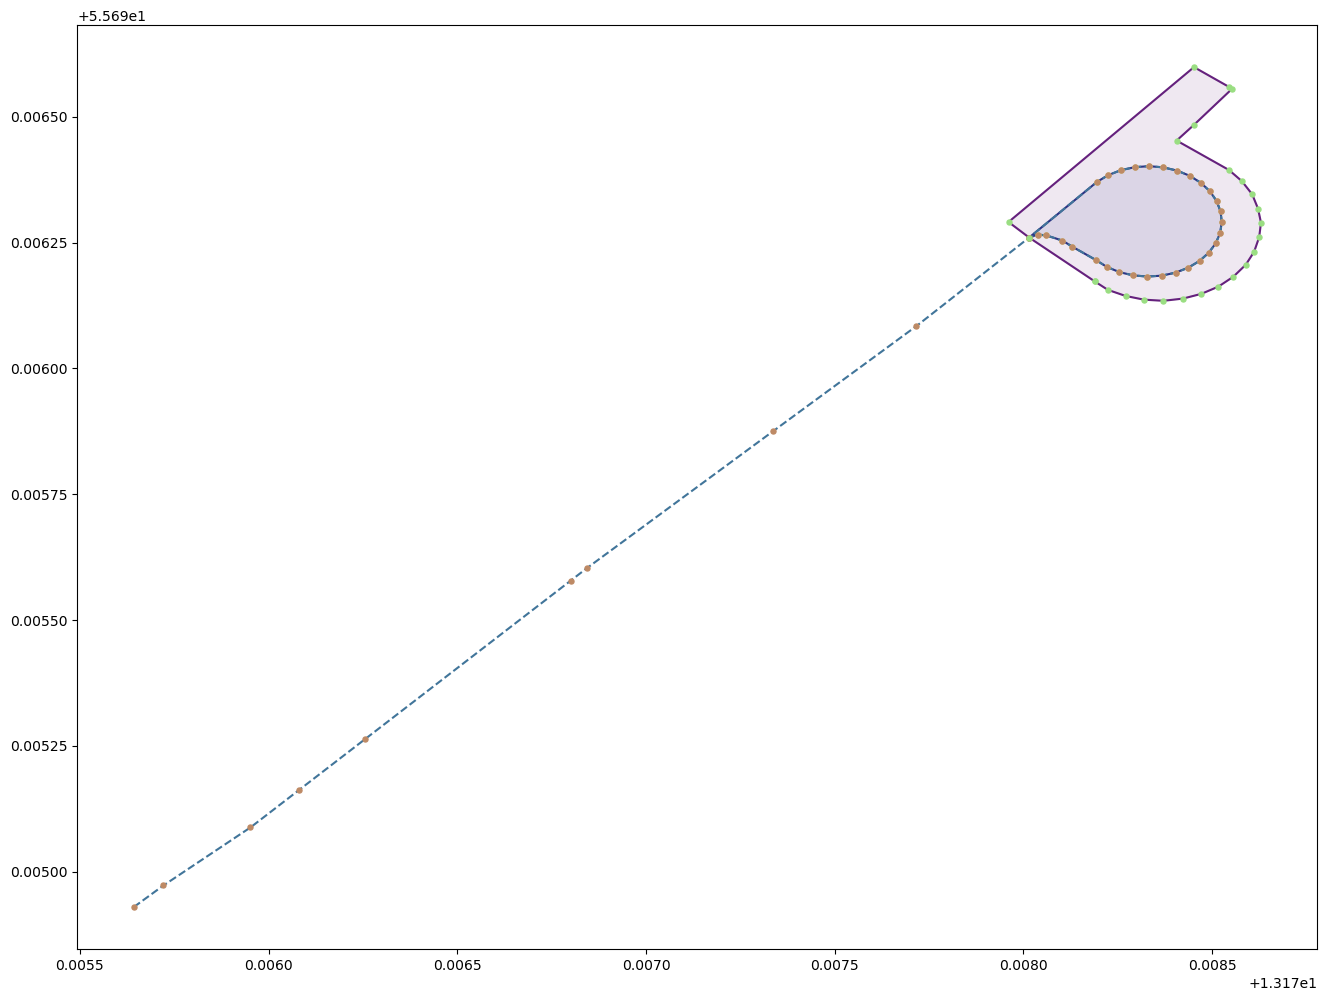

Passed 8894 of 8900. Total in set: 10000
Passed 8994 of 9000. Total in set: 10000
Passed 9094 of 9100. Total in set: 10000
Passed 9194 of 9200. Total in set: 10000
Passed 9294 of 9300. Total in set: 10000
Passed 9394 of 9400. Total in set: 10000
Passed 9494 of 9500. Total in set: 10000
Passed 9594 of 9600. Total in set: 10000
Passed 9694 of 9700. Total in set: 10000
Passed 9794 of 9800. Total in set: 10000
Passed 9894 of 9900. Total in set: 10000
Passed 9994 of 10000. Total in set: 10000
Done. Passed: 10001 of 10007.


Exception: Failed intersection!

In [5]:
total = 0
passed = 0
def evaluate_dataset(data, plot, total, passed):
    for g1, g2 in data:
        #is_intersecting, intersect_points = binary_intersection(g1, g2)

        _, b1 = fpd.compress(g1)
        _, b2 = fpd.compress(g2)
        exp_boolean = shapely.intersects(g1, g2)
        #is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp_boolean, True)
        is_intersecting = fpd.is_intersecting((b1, b2))[1]

        exp_shape = shapely.intersection(g1, g2)
        intersection = chunk_bbox_intersection((b1, b2), exp_boolean, True)

        if plot and exp_boolean: # Now only plotting intersecting shapes
            if False: # Plot chunks?
                plot_chunks_bounds(b1, True, avoid_show=True)
                plot_chunks_bounds(b2, True, avoid_create_frame=True)
            create_canvas(zoom=4)
            geoms = (g1, g2)
            for g in geoms:
                plot_geometry(g, SHOW_GEOMETRIES)
                plot_geometry_bbox(g, SHOW_BOUNDING_BOXES)
                plot_coordinates(g, SHOW_COORDINATES)
            
            plot_common_bbox(geoms, SHOW_COMMON_BOUNDING_BOX)
            #plot_intersecting_points(intersect_points, legends, SHOW_INTERSECTING_POINTS)

            if SHOW_COORDINATES or SHOW_GEOMETRIES or SHOW_INTERSECTING_POINTS or SHOW_COMMON_BOUNDING_BOX or SHOW_BOUNDING_BOXES:
                plt.title("Intersection Plot: " + ('True' if is_intersecting else 'False'))
                plt.show()


            PLOT_RESULTING_INTERSECTION = True
            if is_intersecting and PLOT_RESULTING_INTERSECTION:
                create_canvas(zoom=4)
                for g in geoms:
                    plot_geometry(g, SHOW_GEOMETRIES, alpha=0.1)
                    
                plot_geometry(intersection)
                plot_coordinates(intersection)
                plt.title("Intersecting Shape")
                plt.show()

           
        total += 1
        if is_intersecting == exp_boolean and exp_shape.equals(intersection):
            if not exp_shape.is_empty:
                # create_canvas()
                # plot_geometry(intersection,plot_color='green')
                # plot_geometry(exp_shape, solid=False, plot_color="red")
                #plot_chunks_bounds(fpd.compress(g2)[1], include_next_chunk_start=True)

                plt.show()
            passed += 1
        else:
            print("Above FAILED!")
            print('Expected shape:', exp_shape)
            print('Returned shape:', intersection)
            create_canvas()
            plot_geometry(intersection)
            plot_geometry(g1, solid=False)
            plot_geometry(g2)
            plot_coordinates(intersection)
            plot_coordinates(g1)
            plot_coordinates(g2)
            plt.show()
        if total % 100 == 0:
            print(f"Passed {passed} of {total}. Total in set: {len(data)}")
    return total, passed

total, passed = evaluate_dataset(manual_data, False, total, passed) # Second param: PLOT?
#total, passed = evaluate_dataset(world_data, False, total, passed)
total, passed = evaluate_dataset(lund_data, False, total, passed)

print(f'Done. Passed: {passed} of {total}.')
if passed != total:
    raise(Exception("Failed intersection!"))

#POLYGON ((6.5 6.5, 8 5, 4 4, 6.5 6.5))